# Lab 5: Training CNN

**Author:** Marcus Klang (marcus.klang@cs.lth.se)

**Objectives and Goals:**
  * Design and implement a CNN from scratch using Pytorch
  * Train and evaluate your CNN
  * Reflect on your results, try to improve your CNN by changing the network structure and how you train it (hyperparameters)

**Non-goals:**
  * Spend a wasteful amount of time testing different combinations. We ask you to make 3 reasonable attempts, if these fail, ask for help during a lab session.
  * Use transfer learning. We made the deliberate choice to exclude it. If you know how to build a CNN from scratch, it is straightforward to do transfer learning.

**Requirements for a pass:**
  * You should be able to explain to a TA how you designed your model, how it works, how the provided training code works and how it all fits together - the emphasis is understanding
  * You are expected to implement any method, part or cell that contains the word `TODO` (starting with parts in 2.2 Image Classifer Abstraction)
  * You must train one model on CIFAR10 from scratch that achieves at least **70%** F1 Macro score
  * You must have made 3 reasonable variations of your model (adding, modifying or removing layers) - only one must succeed
  * Test your best model on another dataset of your choice

### CPU vs GPU
The reality is that training CNNs requires a considerable amount of computations, and it is massively accelerated when using GPUs.

You can solve the lab without a GPU, but we have to ask you to be patient as it will take longer time to solve.

### Google Colab
If you only have access to an older or low power laptop without a Pytorch compatible GPU - our recommendation is to at least try Google Colab as it will shorten your training cycles significantly to more manegable levels.

## Preliminaries

### Environment setup instructions

You can find instructions here:
https://canvas.education.lu.se/courses/32297/pages/lab-5-environment


In [1]:
# Imports

# Pytorch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset # Dataloader and Dataset classes to prepare and batch data
from torchvision.transforms.v2 import ToImage, ToDtype, CenterCrop, Resize, Compose, Normalize # Image processing functions from torchvision

# Compute
import numpy as np

# Data
import datasets # Huggingface dataset library to easily download and unpack data
import json
import pickle # saving metrics

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# Utilities
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from typing import Iterable, Tuple, List
from abc import ABCMeta, abstractmethod

## 1. The dataset to be used in the lab: CIFAR10

### Our dataset

We are going to use a commonly available library called `datasets` that provides simple access to many different datasets.   
Take a look at https://huggingface.co/datasets?modality=modality:image&sort=trending if you want to test other image datasets later.

We will be using CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)

The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


### 1.1 Download the dataset

If for any reason the download would fail, we have a fallback. Download [https://fileadmin.cs.lth.se/cs/Education/EDAN96/data/uoft-cs___cifar10.zip], unpack it next to the notebook and change below to:
```python
    ds = datasets.load_dataset("uoft-cs___cifar10")
```

This will use the downloaded directory instead of fetching it from HuggingFace directly.

In [2]:
ds = datasets.load_dataset("uoft-cs/cifar10")

In `ds` we now have two partitions: `train` and `test`

In [3]:
len(ds["train"])

50000

In [4]:
len(ds["test"])

10000

In [5]:
ds["train"]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [6]:
ds["test"]

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

You should now be able to observe that there are 60k images, 50k for training and 10k for evaluation. In addition, there are two *features* `img` and `label`.

The potential labels and their meaning can be given by:

In [7]:
labels = ds["train"].info.features["label"]

In [8]:
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

In [9]:
labels.names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Using the built-in method `int2str` we can translate index to name, there is also a corresponding `str2int` function.

In [10]:
labels.int2str(5)

'dog'

In [11]:
labels.str2int("dog")

5

### 1.2 Visualize the dataset

In [12]:
# Collect the indices per class
label2image_index = {}
for i, lbl in enumerate(ds["train"]["label"]):
    label2image_index.setdefault(lbl, []).append(i)

We are shuffling, which means, everyone will get a different result. Rerun the cell below to see different samples per class

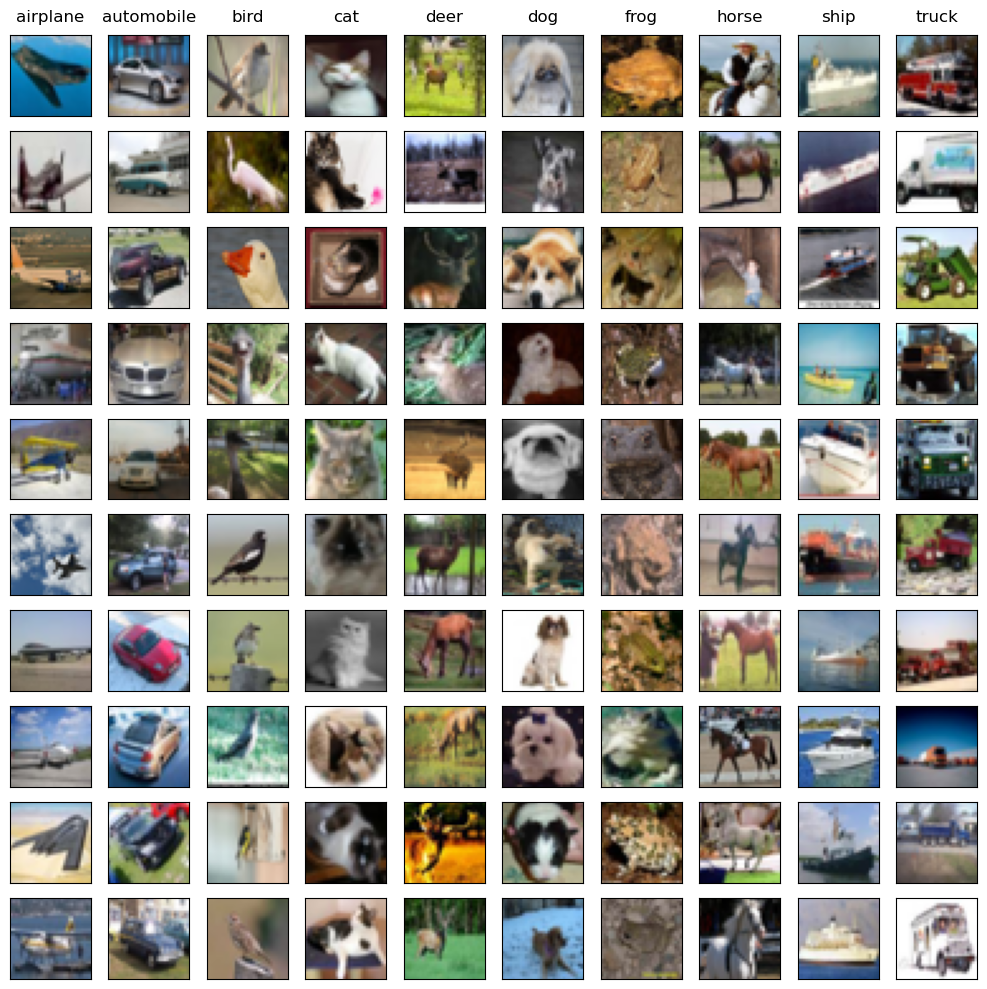

In [13]:
# Shuffle indices
for k,v in label2image_index.items():
    indicies = np.array(v)
    np.random.shuffle(indicies)
    label2image_index[k] = indicies

# Take the first 10
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    indx = i // 10
    lbl = i % 10
    ax.imshow(ds["train"][int(label2image_index[lbl][indx])]["img"])
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks

    if indx == 0:  # Set label for the first column of each row
        ax.set_xlabel(labels.names[lbl], fontsize=12, labelpad=10)
        ax.xaxis.set_label_position('top')  # Set label position to top

plt.tight_layout()
plt.show()

### 1.3 Efficient access to the images during training and evaluation

We will be using the Pytorch dataset classes - we are aware that CIFAR10 is already implemented in Torchvision.    
However, using this approach we can clearly see what is going on and we get access to more datasets.

In [14]:
class HuggingfaceDataset(Dataset):
    def __init__(self, data, indices=None, preprocess=True, image_feat="img", label_feat="label", name=None, resize=None):
        """Dataset constructor

        Parameters:
            data:
                the data as a indexable array
            indices (Optional[List[int]]): 
                the subset of data to use
            preprocess (bool): 
                save processing time, apply preprocessing and save all tensors to memory
            image_feat (str): 
                the name of the image feature that provides X (image)
            label_feat (str): 
                the name of the label fetaure that provides y (class)
            name (str): 
                Name of the dataset e.g. train, val, or test
            resize (Optional[int)]: 
                if set to a value, activates resize and center crop of input images
        """
        self.image_feat = image_feat
        self.label_feat = label_feat

        self.data = data

        # Setup pipeline
        pipeline_steps = [
            ToImage(),  # Convert input to torchvision Image
        ]

        if resize is not None:
            pipeline_steps.extend([
                Resize(resize), # Resize small edge
                CenterCrop(resize), # Center crop to get square image - activate these if you want to test another dataset
            ])

        pipeline_steps.extend([
            ToDtype(torch.float32, scale=True), # Convert to tensors
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Commonly used normalization values
        ])

        self.pipeline = Compose(pipeline_steps)

        self.unnormalize_transform = Compose([
            Normalize(
                mean=[0,0,0],
                std=[1/0.229,1/0.224,1/0.225]),
            Normalize(
                mean=[-0.485,-0.456,-0.406],
                std=[1,1,1]
            )
        ])

        self.preprocess = preprocess
        if preprocess:
            data = []

            image_ids = indices if indices is not None else range(len(self.data))
            desc_text = "Preprocessing..."
            if name is not None:
                desc_text = "Preprocessing %s..." % name
            
            for i in tqdm(image_ids, desc=desc_text):
                d = self.data[int(i)]

                # The RGB is to support grayscale images but our model always expects RGB as input
                tup = self.pipeline(d[self.image_feat].convert("RGB")), d[self.label_feat]
                data.append(tup)
            self.data = data
        elif indices is not None:
            self.data = [data[i] for i in indices]

    def unnormalize(self, img: torch.Tensor):
        """Unormalizes the given tensor
        
        Parameters:
            img: the images to unnormalize
                Tensor of shape `(N, 3, W ,H)` representing one batch of images
        
        Returns:
            Unnormalized tensor of shape `(N, 3, W ,H)` 
        """
        return self.unnormalize_transform(img)

    def __getitem__(self, i):
        assert i >= 0 or i < len(self.data), "invalid image: %d > %d" % (i, len(self.data))

        if self.preprocess:
            return self.data[i]
        else:
            d = self.data[i]
            X, y = self.pipeline(d["img"]), d["label"]
            return X, y

    def __len__(self):
        return len(self.data)

In [15]:
train_ds = HuggingfaceDataset(ds["train"], name="train")

Preprocessing train...:   0%|          | 0/50000 [00:00<?, ?it/s]

We have 10,000 test images, but we need a validation set to check how our training is going without optimizing for what we evaluate on.    
To do this we will pick 20% from the test set and use that as a validation set.

In [16]:
# Reset torch random to get a consistent choice of a test set
torch.manual_seed(3180724873) # just a big random number that is a prime

In [17]:
test_data = torch.randperm(len(ds["test"]))
val_ds = HuggingfaceDataset(ds["test"],indices=test_data[0:2000], name="validation")
test_ds = HuggingfaceDataset(ds["test"],indices=test_data[2000:], name="test")

Preprocessing validation...:   0%|          | 0/2000 [00:00<?, ?it/s]

Preprocessing test...:   0%|          | 0/8000 [00:00<?, ?it/s]

### 2. Setting up our training loop and other utilities

#### 2.1 Metrics

In [18]:
class Metric(metaclass=ABCMeta):
    """Base class for metrics"""
    def __init__(self, record_history=True):
        if record_history:
            self.history_ = []
        else:
            self.history_ = None

    def _add_history(self, value):
        if self.history_ is not None:
            self.history_.append(value)

    @property
    def history(self):
        return self.history_
    
    @property
    def value(self):
        raise NotImplementedError()

    @abstractmethod
    def on_step(self, value)->float:
        raise NotImplementedError()

    @abstractmethod
    def on_epoch(self, epoch)->float:
        raise NotImplementedError()

class EMAValue(Metric):
    """Exponential Moving Average Value - a simple method that smooths data
    
    Tip: increase t_half to make output more smooth if it is too noisy.
    """

    def __init__(self, initial_value=None, t_half=8, record_history=True):
        """Constructor function for EMAValue

        Parameters:
            initial_value (Optional[float]): The starting value
            t_half (int): The half-life, i.e. the number of samples for a step response to get to half
            record_history (bool): record the history of this value

        """
        super().__init__(record_history)
        
        self.alpha = 0.5**(1/t_half)
        self.value_ = initial_value

    def on_step(self, i, value)->float:
        if self.value_ is None:
            self.value_ = value

        self.value_ = (self.alpha)*self.value_ + (1-self.alpha)*value
        self._add_history(self.value_)
        
        return self.value_
    
    def on_epoch(self, epoch):
        return self.value_
    
    @property
    def value(self):
        return self.value_
    
class RawValue(Metric):
    """Raw metric - no smoothing"""
    def __init__(self, record_history=True):
        super().__init__(record_history)
    
    @property
    def value(self):
        return self.value_
    
    def on_step(self, i, value)->float:
        self.value_ = value
        self._add_history(value)
        return self.value

    def on_epoch(self, epoch)->float:
        return self.value_

#### 2.2 Image Classifer Abstraction

This class will serve as the basis for loading up weights, training, predicting and evaluation.

You will be inheriting this class and implement / override relevant methods for your experiments.

Implement missing functionality and make sure you understand how it works.

In [19]:
from typing import Optional, Union
from abc import ABCMeta

class ImageClassifier(metaclass=ABCMeta):
    """Base class for an image classifer in this lab"""

    def __init__(self, device=torch.device("cpu"), n_classes=10, **kwargs):
        self.device = device
        self.n_classes = n_classes
        self.model = None # type: Optional[nn.Module]
        self.hyperparams = dict(**kwargs)
        self.epochs = 0

    def create_metrics(self):
        return {
            "train_loss": EMAValue(),
            "val_loss": EMAValue(),
            "train_acc": EMAValue(),
            "val_acc": EMAValue()
        }

    @abstractmethod
    def create_model(self, **kwargs):
        """Creates a new empty model

        Parameters:
           kwargs: unmapped parameters, you can add named parameters to a concerete 
                   implementation and they will automap from parameters specified 
                   during construction.
        
        Returns
            nn.Module: The model
        """
        raise NotImplementedError()

    def create_loss(self):
        """Create new loss function
        
        Returns
            nn.Module: A loss function
        """
        return nn.CrossEntropyLoss()

    def create_optimizer(self,model,**kwargs):
        """Create an optimizer to use when training"""
        return optim.Adam(model.parameters())

    def initialize(self):
        self.metrics = self.create_metrics()
        self.model = self.create_model(**self.hyperparams)
        self.model.to(self.device)
        self.optimizer = self.create_optimizer(self.model, **self.hyperparams)
        self.loss = self.create_loss()
    
    def _infinite_loader(self,loader: DataLoader)->iter:
        """helper method to provide an endless stream of validation batches"""
        while True:
            for batch in loader:
                yield batch
    
    def _infinite_none(self)->iter:
        """helper method to provide no batches"""
        while True:
            yield None

    def step(self, epoch: int, i: int, loss_value: torch.Tensor):
        """Take one step forward"""
        self.optimizer.zero_grad()
        loss_value.backward()
        self.optimizer.step()

    def collect_metrics(self, 
                        i:int, 
                        train_logits: torch.Tensor, 
                        y_train: torch.Tensor, 
                        train_loss: torch.Tensor, 
                        val_batch: Union[None,Tuple[torch.Tensor,torch.Tensor]]):
        """Collect metrics after stepping
        
        Future improvement: implement skipping to reduce time spent here
        """

        train_y_true = y_train.cpu().numpy()
        train_y_pred = torch.argmax(torch.softmax(train_logits.detach(),dim=1),dim=1).cpu().numpy()
        
        self.metrics["train_loss"].on_step(i, train_loss.item())
        self.metrics["train_acc"].on_step(i, accuracy_score(train_y_true, train_y_pred))

        if val_batch is not None:
            with torch.no_grad():
                self.model.eval()
                X_val, y_val = val_batch
                val_logits = self.model(X_val.to(self.device))
                val_loss = self.loss(val_logits, y_val.to(self.device))
                val_y_pred = torch.argmax(torch.softmax(val_logits, dim=1), dim=1).cpu().numpy()
                val_y_true = y_val.cpu().numpy()

                self.metrics["val_loss"].on_step(i, val_loss.item())
                self.metrics["val_acc"].on_step(i, accuracy_score(val_y_true, val_y_pred))
        
    def predict(self, X:torch.Tensor, logits=False)->torch.Tensor:
        """predict class from a given batch of samples

        Parameters:
            X (torch.Tensor): tensor of shape (N,C,W,H)
            logits (bool): return best class or the raw logits before softmax
        
        Returns:
            Tensor of shape (N,) - the highest scoring class or Tensor fo shape (N,C) when logits is true
        """

        with torch.no_grad():
            self.model.eval()
            outputs = self.model(X)
            
            # If the model returns a tuple, unpack the main output
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            
            if logits:
                return outputs  # Return raw logits
            else:
                return torch.argmax(torch.softmax(outputs, dim=1), dim=1)

    def train_stats(self)->dict:
        """create the entries that should be display during training in the progressbar"""
        return {
            "train_loss":  "%0.4f" % self.metrics["train_loss"].value,
            "train_acc": "%0.1f%%" % (self.metrics["train_acc"].value*100.0),
            "val_loss":  "%0.4f" % self.metrics["val_loss"].value,
            "val_acc": "%0.1f%%" % (self.metrics["val_acc"].value*100.0),
        }
    
    def train(self, train_dl:DataLoader, val_dl:Optional[DataLoader]=None, epochs=10):
        """Train the model
        
        Parameters:
            train_dl: train DataLoader
            val_dl: optional val DataLoader
        """
        if self.model is None:
            self.initialize()

        assert self.model is not None, "Model is unitialized"
        assert self.optimizer is not None, "Optimizer is unitialized"
        assert self.loss is not None, "Loss is unitialized"

        i = 0
        for epoch in range(self.epochs,self.epochs+epochs):
            with tqdm(desc="Epoch %d" % (epoch),total=len(train_dl)) as pbar:
                if val_dl is not None:
                    batches = zip(train_dl,self._infinite_loader(val_dl))
                else:
                    batches = zip(train_dl,self._infinite_none())

                for train_batch, val_batch in batches:
                    self.model.train()
                    
                    X_train, y_train = train_batch
                    X_train = X_train.to(self.device)
                    y_train = y_train.to(self.device)

                    train_logits = self.model(X_train)
                    train_loss = self.loss(train_logits, y_train)

                    self.step(epoch, i, train_loss)
                    self.collect_metrics(i, train_logits, y_train, train_loss, val_batch)

                    pbar.set_postfix(self.train_stats(),refresh=False)
                    pbar.update(1)
                
                for metric in self.metrics.values():
                    metric.on_epoch(epoch)
                
                self.epochs += 1
                i += 1

    def plot_metrics(self):
        fig, ax1 = plt.subplots(figsize=(6, 6))
        ax1.set_xlabel("iteration")
        ax1.set_ylabel("loss")
        ax1.plot(self.metrics["train_loss"].history, label='train loss', color = 'b')
        ax1.plot(self.metrics["val_loss"].history,label='val loss', color='r')
        ax1.legend(title="Loss", loc='upper left', bbox_to_anchor=(0.2, -0.1))
        
        ax2 = ax1.twinx()
        ax2.set_ylabel("accuracy")
        ax2.plot(self.metrics["train_acc"].history,label='train acc', color='g')
        ax2.plot(self.metrics["val_acc"].history, label='val acc', color='y')
        ax2.legend(title="accuracy", loc='upper center', bbox_to_anchor=(0.6, -0.1))

        fig.tight_layout()
        plt.show()

        fig.tight_layout()
        plt.show()

    def evaluate(self, 
                 test_batches: Union[Iterable[Tuple[torch.tensor, torch.tensor]],DataLoader],
                 interactive=True,
                 labels: Optional[List[str]]=None)->Tuple[float,str]:
        """Evaluate your model
        
        Parameters:
            test_batches: iterable that provides all test batches (X, y_true) to evalaute
            interactive (bool): plot and prinout results to screen
            labels: class label names (optional)
        
        Returns:
            Tuple of f1 macro score and the classification report
        """
        self.model.eval()
        y_pred, y_true = [], []
        
        with torch.no_grad():
            for batch in tqdm(test_batches, desc="Evaluating"):
                if isinstance(batch, list) and len(batch) == 2:  # Batch is a list with two elements
                    X_test, y_test = batch
                else:
                    raise ValueError(f"Unexpected batch structure: {type(batch)}, Content: {batch}")

                X_test = X_test.to(self.device)
                y_test = y_test.to(self.device)
                
                predictions = self.predict(X_test, logits=False)
                # Debugging
                print(f"Predictions type: {type(self.predict(X_test, logits=False))}")
                print(f"Predictions content: {self.predict(X_test, logits=False)}")
                
                y_pred.extend(predictions.cpu().numpy())
                y_true.extend(y_test.cpu().numpy())
    
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        clf_report = classification_report(y_true, y_pred, target_names=labels)
        if interactive:
            print("\nClassification Report:")
            print(clf_report)
        
        if interactive:
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot()
        
        score = f1_score(y_true, y_pred, average="macro")
        return score, clf_report


    def load(self, path):
        """Load weights into current model"""
        with open(path + ".meta.json", "r") as fmeta:
            self.hyperparams = json.load(fmeta)

        self.initialize(model_args=self.hyperparams["model"],optimizer_args=self.hyperparams["optimizer"])

        with open(path + ".metrics.pkl", "rb") as fmetrics:
            self.metrics = pickle.load(fmetrics)
        
        self.model.load_state_dict(torch.load(path + ".pth", weights_only=True))

    def save(self, path):
        """Save weights and hyperparameters
        
        Parameters:
        path: start of path
        
        3 files will be created with the following extensions:
          * .pth - model weights
          * .meta.json - hyperparams
          * .metrics.pkl - metrics
        """
        torch.save(self.model.state_dict(), path + ".pth")

        with open(path + ".meta.json", "w") as fmeta:
            json.dump(self.hyperparams, fmeta)

        with open(path + ".metrics.pkl", "wb") as fmetrics:
            pickle.dump(self.metrics, fmetrics, protocol=pickle.HIGHEST_PROTOCOL)
        

## 3. Design yor model

Design one or more candidates, these are Pytorch `nn.Module` with a forward method.

Documentation of available layers and their particulars can be found here:
https://pytorch.org/docs/stable/nn.html

**Hints:**
 * More than 1 classification layer, during our testing a minimum of 2 is required for the network to learn anything
 * Basic ReLU activation after each convolution layer
 * Fewer convolution layers equals larger input to the first linear layer
 * Test your model by providing it with random data to make sure you got the shapes right, e.g: `torch.randn`

In [20]:
class MyCNNClassifier(ImageClassifier):
    def create_model(self, **kwargs):
        return nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 

            nn.Linear(64 * 8 * 8, 128),  
            nn.ReLU(),
            nn.Linear(128, self.n_classes) 
        )
    
# Create a random input tensor simulating a batch of CIFAR-10 images
dummy_input = torch.randn(8, 3, 32, 32)  # Batch size = 8, Channels = 3, Image size = 32x32

classifier = MyCNNClassifier(n_classes=10, device=torch.device("cpu"))
classifier.initialize()  

output = classifier.model(dummy_input)

print("Output shape:", output.shape)  # Expected: [8, 10]

Output shape: torch.Size([8, 10])


## 4. Train your model

### 4.1 Subclass and implement your image classifier

Create a new subclass of `ImageClassifier`

**Recommendations:**
  * We suggest starting with Adam with default parameters as the initial optimizer - during testing it was the most forgiving and converged for most networks.
  * Once you have established it converges, you can make any change you like.

In [21]:
class MyCNNTrainer(ImageClassifier):
    def create_model(self, **kwargs):
        """Create and return the CNN model"""
        return nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 

            nn.Linear(64 * 8 * 8, 128), 
            nn.ReLU(),
            nn.Linear(128, self.n_classes) 
        )

    def create_optimizer(self, model, **kwargs):
        """Create and return the optimizer"""
        return optim.Adam(model.parameters())  # Adam optimizer with default parameters

### 4.2 Setup DataLoaders and train

We need train, validation and test dataloaders. Here you also define the batch size for training.

Hint:
 * Remember to enable drop_last=True - this will prevent the last batch that is not a perfect multiple of number of training samples to be skipped.
 * The test dataloader can have a significantly bigger batch_size, the optimal size is when you computationally bound and overhead is minimal.

In [22]:
from torch.utils.data import DataLoader

train_batch_size = 64
val_batch_size = 64
test_batch_size = 128

train_loader = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, drop_last=True
)
val_loader = DataLoader(
    val_ds, batch_size=val_batch_size, shuffle=False, drop_last=True
)
test_loader = DataLoader(
    test_ds, batch_size=test_batch_size, shuffle=False, drop_last=False
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 781, Val batches: 31, Test batches: 63


In [23]:
device = torch.device("cpu")

model = MyCNNTrainer(n_classes=10, device=device)
model.initialize() 

print(f"Model initialized on {device}.")

Model initialized on cpu.


In [24]:
epochs = 10
model.train(train_dl=train_loader, val_dl=val_loader, epochs=epochs)

Epoch 0:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/781 [00:00<?, ?it/s]

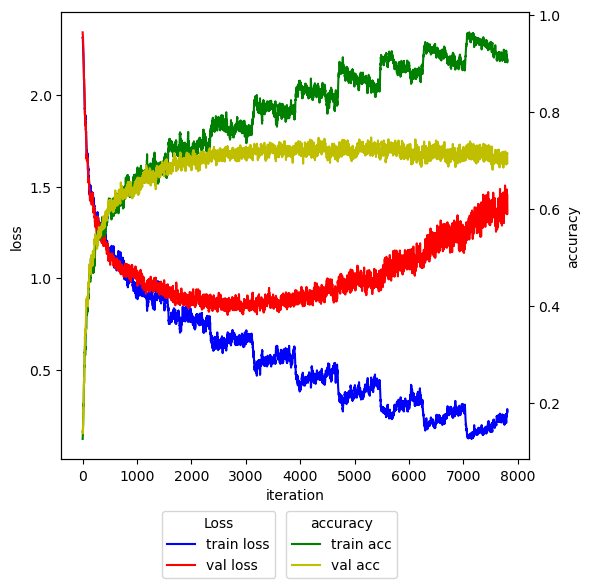

In [25]:
model.plot_metrics()

## 5. Evaluate

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions content: tensor([0, 3, 0, 9, 6, 5, 8, 9, 6, 5, 1, 0, 1, 9, 5, 5, 4, 4, 5, 9, 4, 8, 8, 4,
        6, 4, 6, 4, 7, 3, 4, 3, 9, 1, 5, 3, 9, 3, 5, 8, 8, 8, 1, 7, 6, 3, 4, 7,
        9, 2, 7, 5, 7, 2, 3, 9, 2, 3, 9, 3, 4, 1, 8, 3, 0, 4, 4, 3, 0, 1, 4, 4,
        0, 6, 9, 2, 3, 5, 6, 7, 8, 6, 8, 6, 7, 8, 0, 9, 2, 0, 0, 8, 0, 7, 1, 3,
        2, 3, 8, 7, 4, 1, 9, 7, 8, 4, 5, 5, 0, 8, 5, 9, 7, 9, 9, 2, 7, 2, 2, 2,
        4, 0, 9, 8, 9, 6, 4, 4])
Predictions type: <class 'torch.Tensor'>
Predictions content: tensor([7, 2, 1, 7, 2, 2, 6, 5, 2, 8, 9, 5, 9, 4, 4, 1, 8, 8, 1, 7, 3, 0, 5, 9,
        4, 7, 8, 8, 1, 7, 4, 3, 8, 2, 1, 1, 6, 7, 3, 7, 1, 7, 3, 1, 5, 2, 3, 3,
        5, 1, 4, 8, 3, 9, 1, 6, 7, 8, 9, 1, 8, 2, 6, 0, 0, 8, 3, 4, 7, 3, 5, 2,
        3, 4, 3, 4, 4, 7, 4, 4, 3, 7, 3, 9, 2, 7, 6, 3, 1, 5, 3, 6, 9, 8, 6, 8,
        7, 9, 8, 8, 7, 8, 2, 5, 5, 9, 9, 2, 7, 1, 2, 4, 1, 2, 1, 2, 1, 9, 7, 8,
        4, 8, 4, 3, 4, 7, 1, 3])
Prediction

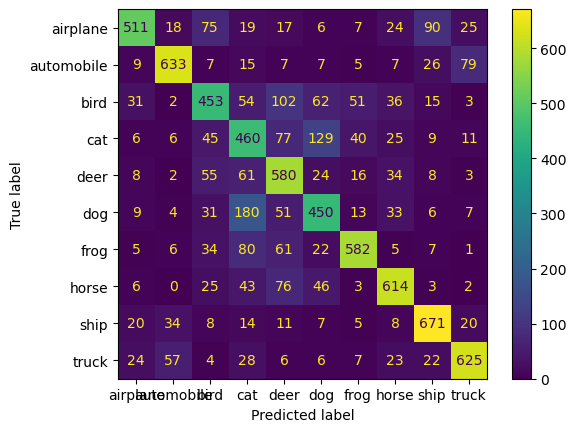

In [26]:
f1_score, clf_report = model.evaluate(
    test_batches=test_loader,
    interactive=True,
    labels=ds['train'].features['label'].names 
)

print(f"F1 Macro Score: {f1_score:.2%}")

## 6. Further experiements

* Test 2 other models and/or parameter variations

In [27]:
# TODO: Write your training and evaluation code for your experiments here

## 7. Test your best model on another dataset of your choice

You can find potential datasets here:
https://huggingface.co/datasets?modality=modality:image&task_categories=task_categories:image-classification&sort=trending

The only requirement for the lab is that you make a resonable attempt at training and evaluating your chosen dataset.

In [28]:
# TODO: Train and evaluate your best model